In [1]:
%matplotlib inline
from pprint import pprint
from decimal import Decimal
import itertools
import seaborn
import pandas

import simulate
import harvesting
import market
import withdrawal
import numpy

/Users/justus/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
series = market.Returns_US_1871()

In [3]:
TYPE = 'Withdrawal (Real)'
m = {'Withdrawal (Nominal)': lambda x: float(x.withdraw_n),
     'Withdrawal (Real)' : lambda x: float(x.withdraw_r),
     'Portfolio (Nominal)': lambda x: float(x.portfolio_n),
     'Portfolio (Real)': lambda x: float(x.portfolio_r),
}
lens = m[TYPE]
lens.__label__ = TYPE

def fn(x):
    return [lens(_) for _ in x]

year = 1980

def diff(x):
    (a, b) = itertools.tee(fn(x))
    for n in zip(list(a), [0.1] + list(b)):
        print(round((n[0] - n[1]) / n[1] * 1000) / 10)
        
def check_stat(x):
    (a, b) = itertools.tee(fn(x))
    diffs = [n[0] - n[1] for n in zip(list(a), [0] + list(b))]
    return(numpy.std(diffs[1:]))

VPW_YEARS=40
w = {
    'longinvest': lambda p, s: withdrawal.LonginvestSmoothing(withdrawal.VPW(p, s, years_left=VPW_YEARS)),
    'steiner' : lambda p, s: withdrawal.SteinerSmoothing(withdrawal.VPW(p, s, years_left=VPW_YEARS)),
    'rolling' : lambda p, s: withdrawal.RollingAverageSmoothing(withdrawal.VPW(p, s, years_left=VPW_YEARS)),
    'raw' : lambda p, s: withdrawal.VPW(p, s, years_left=VPW_YEARS),
    'cape10' : lambda p, s: withdrawal.CAPE10Smoothing(year, withdrawal.VPW(p, s, years_left=VPW_YEARS)),
    'rollingcape10' : lambda p, s: withdrawal.RollingAverageSmoothing(withdrawal.CAPE10Smoothing(year, withdrawal.VPW(p, s, years_left=VPW_YEARS))),
    'inverted' : lambda p, s: withdrawal.TiltCapital(p, s, tilt=Decimal('.3333')),
    'stout' : lambda p, s: withdrawal.Model3(p, s),
    'prime' : lambda p, s: withdrawal.PMTPrime(p),
}

def run_sim(year, key, length=15):
    portfolio = (500000,500000)
    harvest_strategy = harvesting.make_rebalancer(0.5)
    
    return simulate.withdrawals(series.iter_from(year),
                                 withdraw=w[key],
                                 years=length,
                                 portfolio=portfolio,
                                 harvesting=harvest_strategy)


pmt = run_sim(year, 'raw')
long = run_sim(year, 'longinvest')
steiner = run_sim(year, 'steiner')
rolling = run_sim(year, 'rolling')
cape10 = run_sim(year, 'cape10')
rollingcape10 = run_sim(year, 'rollingcape10')
inverted = run_sim(year, 'inverted')
stout = run_sim(year, 'stout')
prime = run_sim(year, 'prime')

Text(0.5, 0.98, 'Retirement in 1980')

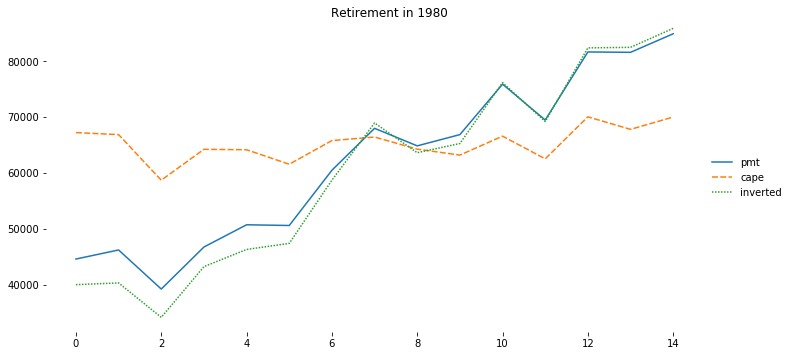

In [4]:
df = pandas.DataFrame({
    'pmt' : [lens(x) for x in pmt],
    'cape' : [lens(x) for x in cape10],
    'inverted' : [lens(x) for x in inverted],
})
g = seaborn.relplot(
        data=df,
        kind='line',
        aspect=2,
    )
#g.fig.autofmt_xdate()
g.despine(left=True, bottom=True, offset=20)
g.fig.suptitle(f'Retirement in {year}')

In [5]:
df

,pmt,cape,inverted
0,44587.000000,67226.000000,40000.200000
1,46210.194671,66860.536502,40310.196038
2,39214.098937,58702.426597,34147.908905
3,46735.919058,64231.534837,43224.583628
4,50721.187562,64153.152025,46301.821393
5,50592.135803,61560.308643,47390.992470
6,60478.616652,65792.881062,58700.797668
7,67988.823530,66431.917648,68945.144119
8,64847.390816,64262.503467,63625.833649
9,66862.031537,63195.071371,65269.109387


In [6]:
def rainy_day(actual, goal):
    return abs(sum([g-a for (g, a) in zip(fn(goal), fn(actual))]))

def make_ratio(actual, goal):
    # a lower standard deviation is better, so we need to take the inverse of it.
    # a lower rainy day fund is better
    # the higher this ratio the better

    # the numbers we generate are tiny, so scale them up to make them
    # easier for a human to eyeball
    SCALING_FACTOR = 1000000000
    return (1/check_stat(actual)) / rainy_day(actual, pmt) * SCALING_FACTOR

#import pprint
#pprint.pprint([g-a for (g, a) in zip(fn(pmt), fn(rolling))])

print("pmt", check_stat(pmt))
#print("long", make_ratio(long, pmt), check_stat(long), rainy_day(long, pmt))
#print("steiner", make_ratio(steiner, pmt), check_stat(steiner), rainy_day(steiner, pmt))
print("rolling", make_ratio(rolling, pmt), check_stat(rolling), rainy_day(rolling, pmt))
print("cape10", make_ratio(cape10, pmt), check_stat(cape10), rainy_day(cape10, pmt))
print("rollingcape10", make_ratio(rollingcape10, pmt), check_stat(rollingcape10), rainy_day(rollingcape10, pmt))
#print("inverted", make_ratio(inverted, pmt), check_stat(inverted), rainy_day(inverted, pmt))
#print("stout", make_ratio(stout, pmt), check_stat(stout), rainy_day(stout, pmt))

pmt 5721.570568814196
rolling 7.247562405318286 2802.5937010016473 49232.04715592719
cape10 5.273479947798666 3982.330577662107 47617.3686605446
rollingcape10 19.681875906977854 2274.9435803234396 22333.81324751451


In [7]:
key = 'rolling'
vals = []
for i in range(1871, 1985):
    pmt = run_sim(i, 'raw')
    actual = run_sim(i, key)
    #ratio = make_ratio(actual, pmt)
    ratio = check_stat(actual)
    #print(i, ratio)
    vals.append(ratio)
vals.remove(max(vals))
print('mean', numpy.mean(vals))
print('median', numpy.median(vals))
print('stdev', numpy.std(vals))

mean 3039.477612231467
median 2936.2697632046597
stdev 821.0448815774878
